In [146]:
from pyscf import scf, gto, fci
from openfermionpyscf._run_pyscf import compute_integrals, generate_molecular_hamiltonian
from openfermion import InteractionOperator, FermionOperator
from openparticle import ParticleOperator, get_fock_basis, generate_matrix
import numpy as np
from functools import partial
import sys, os

sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))
import cirq
from colors import *
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
from src.lobe.system import System
from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.asp import get_target_state, add_prepare_circuit
from pauli_lcu import lcuify
from src.lobe.metrics import CircuitMetrics
from src.lobe.index import index_over_terms
from tests._utils import _validate_block_encoding
from src.lobe.lcu import LCU
from src.lobe._utils import get_basis_of_full_system
from src.lobe.rescale import rescale_coefficients
from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.system import System

In [149]:
# basis = 'cc-pvdz' # double
# basis = 'cc-pvtz' # triple
# basis = 'cc-pvqz' # quadruple

In [14]:
def get_nonzero_terms(arr, tol=1e-10):
    """
    """
    where_nonzero = np.where(~np.isclose(arr, 0, atol=tol))
    nonzero_indices = list(zip(*where_nonzero))
    return dict(zip(nonzero_indices, arr[where_nonzero]))

In [15]:
def preprocess_terms(term):
    modes, types = [op[1] for op in list(term.op_dict)[0]], [op[2] for op in list(term.op_dict)[0]]

    processed_types = []
    processed_modes = []
    skip_next = False
    for mode in range(len(modes) - 1):
        if skip_next:
            skip_next = False
            continue
        else:
            if modes[mode] == modes[mode + 1]:
                processed_types.append(2)
                processed_modes.append(modes[mode])
                skip_next = True
            else:
                processed_types.append(types[mode])
                processed_modes.append(modes[mode])

    if not skip_next:
        processed_modes.append(modes[-1])
        processed_types.append(types[-1])
    return processed_modes[::-1], processed_types[::-1]

In [16]:
def get_coeff_vector(groups):
    for term in groups:
        print(term.to_list()[0].coeff)

In [150]:
def get_water_hamiltonian():
    geom = [
            ("O", (0, 0, 0.1173)),
            ("H", (0, 0.07572, -0.4692)),
            ("H", (0, -0.07572, -0.4692)),
        ]
    basis = "sto-3g"

    mol = gto.M(
        atom=geom,
        basis = basis,
        unit='A').build()
    hf_obj = scf.RHF(mol)
    hf_obj.kernel()
    one_electron_integrals, two_electron_integrals = compute_integrals(mol, hf_obj)

    hcore = np.zeros([mol.nao*2]*2)
    hcore[ ::2, ::2] = one_electron_integrals
    hcore[1::2,1::2] = one_electron_integrals

    eri = np.zeros([mol.nao*2]*4)
    eri[ ::2, ::2, ::2, ::2] = two_electron_integrals
    eri[1::2,1::2,1::2,1::2] = two_electron_integrals
    eri[0::2,1::2,1::2,0::2] = two_electron_integrals
    eri[1::2,0::2,0::2,1::2] = two_electron_integrals

    one_body_coefficients = get_nonzero_terms(hcore)
    two_body_coefficients = get_nonzero_terms(eri)

    fermionic_molecular_hamiltonian = FermionOperator()
    for (p,q), coeff in one_body_coefficients.items():
            fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}', coeff)
    for (p,q,r,s), coeff in two_body_coefficients.items():
            if p != q and r != s:
                    fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}^ {r} {s}', coeff*.5)

    op_fermionic_molecular_hamiltonian = ParticleOperator.from_openfermion(
           fermionic_molecular_hamiltonian
    )

    return op_fermionic_molecular_hamiltonian

In [131]:
def get_chain_hamiltonian(chain_length, bond_length: float = 1):
    geom = [('H', (0, 0, bond_length * i)) for i in np.arange(0, chain_length)]
    basis = 'sto-3g'

    mol = gto.M(
        atom=geom,
        basis = basis,
        unit='A').build()
    hf_obj = scf.RHF(mol)
    hf_obj.kernel()
    one_electron_integrals, two_electron_integrals = compute_integrals(mol, hf_obj)

    hcore = np.zeros([mol.nao*2]*2)
    hcore[ ::2, ::2] = one_electron_integrals
    hcore[1::2,1::2] = one_electron_integrals

    eri = np.zeros([mol.nao*2]*4)
    eri[ ::2, ::2, ::2, ::2] = two_electron_integrals
    eri[1::2,1::2,1::2,1::2] = two_electron_integrals
    eri[0::2,1::2,1::2,0::2] = two_electron_integrals
    eri[1::2,0::2,0::2,1::2] = two_electron_integrals

    one_body_coefficients = get_nonzero_terms(hcore)
    two_body_coefficients = get_nonzero_terms(eri)

    fermionic_molecular_hamiltonian = FermionOperator()
    for (p,q), coeff in one_body_coefficients.items():
            fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}', coeff)
    for (p,q,r,s), coeff in two_body_coefficients.items():
            if p != q and r != s:
                    fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}^ {r} {s}', coeff*.5)

    op_fermionic_molecular_hamiltonian = ParticleOperator.from_openfermion(
           fermionic_molecular_hamiltonian
    )

    return op_fermionic_molecular_hamiltonian

In [152]:
def get_metrics(chain_length: int = None):
#     op_fermionic_molecular_hamiltonian = get_chain_hamiltonian(chain_length)
    op_fermionic_molecular_hamiltonian = get_water_hamiltonian()
    groups = op_fermionic_molecular_hamiltonian.group()

    number_of_block_encoding_ancillae = 1
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(groups)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_ancillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]

    system = System(
            0,
            1000,
            number_of_fermionic_modes=op_fermionic_molecular_hamiltonian.max_fermionic_mode + 1,
            number_of_bosonic_modes=0,
    )


    block_encoding_functions = []
    rescaling_factors = []

    for term in groups:
        if len(term.to_list()) == 1:
                term = term.mode_order()
                active_indices, operator_types = preprocess_terms(term)
                block_encoding_functions.append(
                partial(
                        fermionic_product_block_encoding,
                        system = system,
                        block_encoding_ancillae = block_encoding_ancillae,
                        active_indices=active_indices,
                        sign = np.sign(term.coeff),
                        operator_types=operator_types,
                        clean_ancillae=clean_ancillae[10:],
                        ctrls=ctrls)
                )
                rescaling_factors.append(1)

        else:
                term = term.to_list()[0].mode_order()
                active_indices, operator_types = preprocess_terms(term)
                block_encoding_functions.append(
                partial(
                        fermionic_plus_hc_block_encoding,
                        system = system,
                        block_encoding_ancillae = block_encoding_ancillae,
                        active_indices=active_indices,
                        sign = np.sign(term.coeff),
                        operator_types=operator_types,
                        clean_ancillae=clean_ancillae[10:],
                        ctrls=ctrls
                        )
                )
                rescaling_factors.append(1)

    gates = []
    lobe_metrics = CircuitMetrics()

    rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
    [np.abs(term.to_list()[0].coeff) for term in groups],
    rescaling_factors
    )
    target_state = get_target_state(rescaled_coefficients)

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _lobe_metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    lobe_metrics += _lobe_metrics

    _gates, _lobe_metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    lobe_metrics += _lobe_metrics

    _gates, _lobe_metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    lobe_metrics += _lobe_metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    lcu_results = lcuify(op_fermionic_molecular_hamiltonian, zero_threshold=1e-12)
    lobe_results = (lobe_metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_ancillae, system.number_of_system_qubits)
    
    
    return lobe_results, lcu_results


In [153]:
METRICS = [get_metrics()]

converged SCF energy = -71.3530498475541
Too many qubits to validate: 27


In [160]:
METRICS[0][0][0].number_of_elbows, METRICS[0][0][0].number_of_nonclifford_rotations, METRICS[0][1][0].number_of_elbows, METRICS[0][1][0].number_of_nonclifford_rotations,

(2064, 2044, 1085, 4085)

In [141]:
n_chains = np.arange(2, 10, 2)
METRICS = [get_metrics(n) for n in n_chains]

converged SCF energy = -1.06610864931794
converged SCF energy = -2.09854593699772
Too many qubits to validate: 18
converged SCF energy = -3.13553221396632
Too many qubits to validate: 24
converged SCF energy = -4.17436981038916
Too many qubits to validate: 30


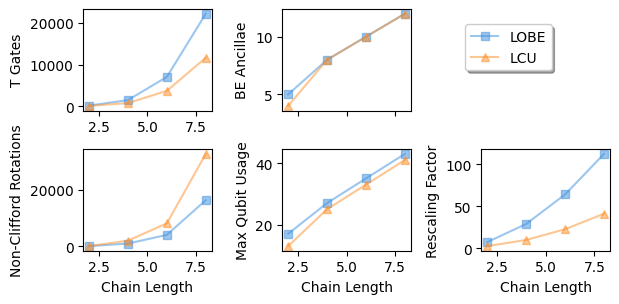

In [142]:
fig, axes = plt.subplots(2, 3, figsize=(16 / 2.54, 8 / 2.54))

axes[0][0].plot(n_chains, [(4*METRICS[i][0][0].number_of_elbows) + METRICS[i][0][0].number_of_t_gates for i in range(len(n_chains))], color=BLUE, marker='s', alpha = 0.5, label = 'LOBE')
axes[0][0].plot(n_chains, [(4*METRICS[i][1][0].number_of_elbows) + METRICS[i][1][0].number_of_t_gates for i in range(len(n_chains))], color=ORANGE, marker='^', alpha = 0.5, label = "LCU")
axes[0][0].set_ylabel('T Gates')

axes[1][0].plot(n_chains, [(4*METRICS[i][0][0].number_of_nonclifford_rotations) for i in range(len(n_chains))], color=BLUE, marker='s', alpha = 0.5, label = 'LOBE')
axes[1][0].plot(n_chains, [(4*METRICS[i][1][0].number_of_nonclifford_rotations) for i in range(len(n_chains))], color=ORANGE, marker='^', alpha = 0.5, label = "LCU")
axes[1][0].set_ylabel('Non-Clifford Rotations')
axes[1][0].set_xlabel('Chain Length')

axes[0][1].plot(n_chains, [METRICS[i][0][2] for i in range(len(n_chains))], color=BLUE, marker='s', alpha = 0.5)
axes[0][1].plot(n_chains, [METRICS[i][1][2] for i in range(len(n_chains))], color=ORANGE, marker='^', alpha = 0.5)
axes[0][1].set_ylabel("BE Ancillae")
axes[0][1].set_xticklabels([])

axes[1][2].plot(n_chains, [METRICS[i][0][1] for i in range(len(n_chains))], color=BLUE, marker='s', alpha = 0.5)
axes[1][2].plot(n_chains, [METRICS[i][1][1] for i in range(len(n_chains))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][2].set_ylabel("Rescaling Factor")
axes[1][2].set_xlabel('Chain Length')

axes[1][1].plot(n_chains, [METRICS[i][0][0].ancillae_highwater() + METRICS[i][0][2] + METRICS[i][0][3] + 1 for i in range(len(n_chains))], color=BLUE, marker='s', alpha = 0.5)
axes[1][1].plot(n_chains, [METRICS[i][1][0].ancillae_highwater() + METRICS[i][1][2] + METRICS[i][1][3] + 1 for i in range(len(n_chains))], color=ORANGE, marker='^', alpha = 0.5)
axes[1][1].set_ylabel("Max Qubit Usage")
axes[1][1].set_xlabel('Chain Length')

fig.delaxes(axes[0][2])
plt.tight_layout()
axes[1][0].legend(loc='upper right', bbox_to_anchor=(3.7, 2.3),
          fancybox=True, shadow=True, ncol=1)



In [144]:
chain_ham = get_chain_hamiltonian(4)

converged SCF energy = -2.09854593699772


In [145]:
len(chain_ham.group()), chain_ham.to_paulis(max_fermionic_mode=chain_ham.max_fermionic_mode + 1).n_terms

(110, 185)